# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  







# Readings
1. (torchtext 1) https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-ii-f146c8b9a496
1. (torchtext 2) http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
1. (torchtext 3) http://mlexplained.com/2018/02/15/language-modeling-tutorial-in-torchtext-practical-torchtext-part-2/
1. (torchtext 4) http://anie.me/On-Torchtext/
1. (conv 1) https://medium.com/@TalPerry/convolutional-methods-for-text-d5260fd5675f
1. (conv 2) http://debajyotidatta.github.io/nlp/deep/learning/word-embeddings/2016/11/27/Understanding-Convolutions-In-Text/

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim
import spacy
import matplotlib.pyplot as plt

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator

from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm_notebook as tqdm


SEED = 42
np.random.seed(SEED)

from sklearn.base import BaseEstimator, ClassifierMixin

# Готовим данные

In [2]:
!head imdb_master.csv

In [3]:
import spacy


spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]            

In [4]:
classes={
    'neg':0,
    'unsup':1,
    'pos':2
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))
LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

dataset = TabularDataset('imdb_master.csv', format='csv', 
                         fields=[(None, None), (None, None), ('review', TEXT),('label', LABEL), (None, None)], 
                         skip_header=True)

Выборку делю сама, не так, как на kaggle (разрешили оставить так)

In [5]:
train, test = dataset.split(0.7, stratified=True)
train, valid = train.split(0.7, stratified=True)
print(np.unique([x.label for x in train.examples], return_counts=True))
print(np.unique([x.label for x in valid.examples], return_counts=True))
print(np.unique([x.label for x in test.examples], return_counts=True))

(array([0, 1, 2]), array([12250, 24500, 12250]))
(array([0, 1, 2]), array([ 5250, 10500,  5250]))
(array([0, 1, 2]), array([ 7500, 15000,  7500]))


In [6]:
batch_size = 64
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review)
)

# Функции

In [7]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, dropout, embedding, freeze):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding, freeze=freeze)
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [8]:
class MyClass(BaseEstimator, ClassifierMixin):
    
    def __init__(self, vocab_size, embed_size,
                 hidden_size, kernels,
                 dropout, embedding, freeze,
                 train_iterator, valid_iterator, test_iterator,
                 n_epochs, random=False, lr=0.01):
        self.vocab_size=vocab_size
        self.embed_size=embed_size
        self.hidden_size=hidden_size
        self.kernels=kernels
        self.dropout=dropout
        self.embedding=embedding
        self.freeze=freeze
        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator
        self.test_iterator = test_iterator
        self.n_epochs = n_epochs
        self.learning_rates = []
        self.losses_train = []
        self.losses_valid = []
        self.random = random
        self.lr=lr
        
    def train(self):
        tt.cuda.empty_cache()
        self.model_nn = CNN(vocab_size=self.vocab_size,
                            embed_size=self.embed_size,
                            hidden_size=self.hidden_size,
                            kernels=self.kernels,
                            dropout=self.dropout,
                            embedding=self.embedding,
                            freeze=self.freeze)
        if self.random:
            self.model_nn.embedding = nn.Embedding(self.vocab_size, self.embed_size)
            nn.init.uniform_(self.model_nn.embedding.weight)
            
        optimizer = tt.optim.Adam(self.model_nn.parameters(), lr=self.lr)
        scheduler = tt.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
        criterion = nn.CrossEntropyLoss()
        
        early_k = 0
        min_loss = float('inf')
        for i in tqdm(range(self.n_epochs)):
            # train
            epoch_loss = 0
            self.model_nn.train()
            for batch in tqdm(self.train_iterator):
                # Run the forward pass
                predictions = self.model_nn.forward(batch.review[0])
                loss = criterion(predictions, batch.label)
                epoch_loss += loss.item()
                # Backprop and perform Adam optimisation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            epoch_loss_train =  epoch_loss / len(self.train_iterator)
            self.losses_train.append(epoch_loss_train)
            self.learning_rates.append(optimizer.param_groups[0]['lr'])
            print('loss_train', epoch_loss_train)
        
            # validation
            epoch_loss = 0
            # self.model_nn.eval()
            with tt.no_grad():
                for batch in tqdm(self.valid_iterator):
                    predictions = self.model_nn.forward(batch.review[0])
                    loss = criterion(predictions, batch.label)
                    epoch_loss += loss.item()
                epoch_loss_val =  epoch_loss / len(self.valid_iterator)
                self.losses_valid.append(epoch_loss_val)
                print('loss_valid', epoch_loss_val)
                if loss < min_loss:
                    min_loss = loss
                    early_k = 0
                else:
                    early_k += 1
                if early_k > 10:
                    break
            scheduler.step(epoch_loss)
            
    def predict_proba(self, test):
        pred = self.model_nn.forward(test)
        pred = tt.softmax(pred, dim=-1)
        pred = pred.detach().numpy()
        return pred
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return proba.argmax(axis=1)
    
    def evaluate_loss(self):
        losses = 0
        for batch in tqdm(self.test_iterator):
            predictions = self.predict_proba(batch.review[0])
            losses += log_loss(batch.label.detach().numpy(), predictions, labels=[0, 1, 2])
        return losses / len(self.test_iterator)
    
    def evaluate_accuracy(self):
        accs = 0
        for batch in tqdm(self.test_iterator):
            predictions = self.predict(batch.review[0])
            accs += accuracy_score(batch.label, predictions)
        return accs / len(self.test_iterator)

# 1 модель
#### Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, freeze=True)`. You can download any pretrained embeddings you like.

Скачиваем эмбеддинги:

In [9]:
TEXT.build_vocab(dataset, min_freq=10, vectors="glove.6B.100d")
LABEL.build_vocab(dataset)

In [9]:
pretrained_embedding = TEXT.vocab.vectors
vocab_size=len(TEXT.vocab.itos)
embed_size=100
hidden_size=128
kernels=[2,3,4,5]
dropout=0.5
embedding=pretrained_embedding
freeze=True
n_epochs=50

my = MyClass(vocab_size=vocab_size, embed_size=embed_size,
             hidden_size=hidden_size, kernels=kernels,
             dropout=dropout, embedding=embedding, 
             freeze=freeze, train_iterator=train_iterator,
             valid_iterator=valid_iterator, test_iterator=test_iterator,
             n_epochs=n_epochs)
my.train()

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Epoch     9: reducing learning rate of group 0 to 1.0000e-03.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Epoch    20: reducing learning rate of group 0 to 1.0000e-04.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [10]:
my.evaluate_loss()

A Jupyter Widget

1.2901751205539047

In [11]:
my.evaluate_accuracy()

A Jupyter Widget

0.4743359097370291

In [20]:
def plot_curves(losses_train, losses_valid, step=1):
    plt.plot(range(1, len(losses_train)+1), losses_train)
    plt.plot(range(1, len(losses_train)+1), losses_valid)
    plt.legend(['train', 'validation'], loc='lower right')
    plt.title('Validation curves')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xticks(np.arange(1, len(losses_train)+1, step=step))
    plt.show()

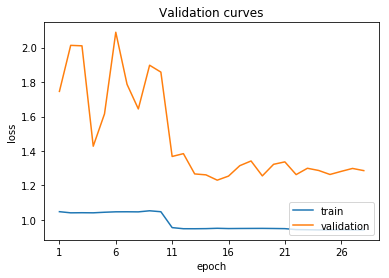

In [13]:
plot_curves(my.losses_train, my.losses_valid, step=5)

In [21]:
def learning_curve(learning_rates, step=1):
    plt.plot(range(1, len(learning_rates)+1), learning_rates)
    plt.legend(['train', 'validation'], loc='lower right')
    plt.title('Learning rate curve')
    plt.xlabel('epoch')
    plt.ylabel('learning_rate')
    plt.xticks(np.arange(0, len(learning_rates)+1, step=step))
    plt.yticks(np.arange(0, 0.01, step=0.001))
    plt.show()

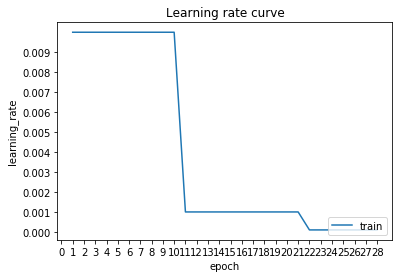

In [43]:
learning_curve(my.learning_rates)

## Мини-вывод по 1 модели:
Кривые в итоге начинают сходиться, а не расходиться. Если эти кривые бы начали последовательно расходиться, это могло бы быть признаком прекращения обучения в более раннюю эпоху, но этого тут не происходит. Валидационная кривая в итоге получила loss примерно на `1.29`. На каждой эпохе мы видим, что ошибка на валидационных данных снижается (в том числе из-за оптимизации), что хорошо. Однако, у нас валидационный loss больше тренировочного, что может значить переобучением. Так на новых данных наша модель может сработать не совсем хорошо. Так как все-таки кривые сближаются, значит, что вероятность переобучения падает (Typically validation loss should be similar to but slightly higher than training loss.) Результат на тестовой выборке (accuracy) равен `0.47`.

Learning rate у нас оптимизировался два раза (на 9 эпохе и 20). Значит на этих эпохах мы приближались к оптимуму и надо было уменьшить шаг (чтобы не перешагнуть его).

Ранний стоп случился на 27 эпохе.

# 2 модель
#### Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, freeze=False)`

In [14]:
tt.cuda.empty_cache()
pretrained_embedding = TEXT.vocab.vectors
vocab_size=len(TEXT.vocab.itos)
embed_size=100
hidden_size=128
kernels=[2,3,4,5]
dropout=0.5
embedding=pretrained_embedding
freeze=False
# уменьшим кол-во эпох (это не первый запуск, и видила, что после 5 эпохи уже идет переобучение - см. ниже)
n_epochs=8

In [15]:
my = MyClass(vocab_size=vocab_size, embed_size=embed_size,
             hidden_size=hidden_size, kernels=kernels,
             dropout=dropout, embedding=embedding, 
             freeze=freeze, train_iterator=train_iterator,
             valid_iterator=valid_iterator, test_iterator=test_iterator,
             n_epochs=n_epochs)
my.train()

A Jupyter Widget

A Jupyter Widget

loss_train 0.7121902694512285


A Jupyter Widget

loss_valid 2.7219520722116743


A Jupyter Widget

loss_train 0.5846800007723642


A Jupyter Widget

loss_valid 2.5915272007597254


A Jupyter Widget

loss_train 0.5024603431942257


A Jupyter Widget

loss_valid 3.7794411157039884


A Jupyter Widget

loss_train 0.44124791096146987


A Jupyter Widget

loss_valid 4.058750516737848


A Jupyter Widget

loss_train 0.40426413121562715


A Jupyter Widget

loss_valid 4.653068192099365


A Jupyter Widget

loss_train 0.3654596459791648


A Jupyter Widget

loss_valid 5.169219649127914


A Jupyter Widget

loss_train 0.33003392981914875


A Jupyter Widget

loss_valid 5.713302561214992


A Jupyter Widget

loss_train 0.30839526668852363


A Jupyter Widget

loss_valid 5.982744473816776
Epoch     7: reducing learning rate of group 0 to 1.0000e-03.


In [17]:
my.evaluate_loss()

A Jupyter Widget

5.7155257940323745

In [18]:
my.evaluate_accuracy()

A Jupyter Widget

0.5732387171286425

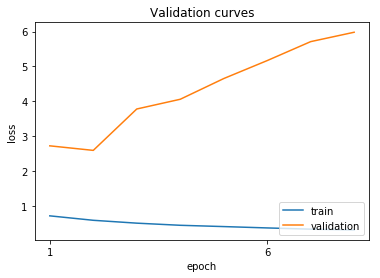

In [22]:
plot_curves(my.losses_train, my.losses_valid, step=5)

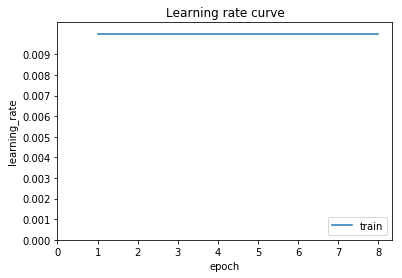

In [23]:
learning_curve(my.learning_rates)

Это пример, когда я обучала на большемколичестве эпохах. Остановила, так как переобучение. Я заново переобучила, так как забыла про график

In [14]:
my = MyClass(vocab_size=vocab_size, embed_size=embed_size,
             hidden_size=hidden_size, kernels=kernels,
             dropout=dropout, embedding=embedding, 
             freeze=freeze, train_iterator=train_iterator,
             valid_iterator=valid_iterator, test_iterator=test_iterator,
             n_epochs=n_epochs)
my.train()

A Jupyter Widget

A Jupyter Widget

loss_train 0.9438268143887931


A Jupyter Widget

loss_valid 1.7292047418359564


A Jupyter Widget

loss_train 0.742279226957351


A Jupyter Widget

loss_valid 2.315415077296434


A Jupyter Widget

loss_train 0.5950498767683462


A Jupyter Widget

loss_valid 3.0705681171460717


A Jupyter Widget

loss_train 0.5077129130108238


A Jupyter Widget

loss_valid 2.719718869333934


A Jupyter Widget

loss_train 0.4425014289528832


A Jupyter Widget

loss_valid 3.9101084938165265


A Jupyter Widget

loss_train 0.3932149281078468


A Jupyter Widget

loss_valid 5.033168701053028


A Jupyter Widget

loss_train 0.3577161663875723


A Jupyter Widget

loss_valid 5.671115573778703
Epoch     6: reducing learning rate of group 0 to 1.0000e-03.


A Jupyter Widget

loss_train 0.19599961819170972


A Jupyter Widget

loss_valid 8.050296213851512


A Jupyter Widget

loss_train 0.16825821935916538


A Jupyter Widget

loss_valid 8.790889141407419


A Jupyter Widget

loss_train 0.15226622027717043


A Jupyter Widget

loss_valid 9.332200265582934


A Jupyter Widget

loss_train 0.13786780839547633


A Jupyter Widget

loss_valid 10.434087341679628


A Jupyter Widget

loss_train 0.12593420215592993


A Jupyter Widget

loss_valid 11.332485183031725


A Jupyter Widget

loss_train 0.1154767969141741


A Jupyter Widget

loss_valid 12.543963933788172


A Jupyter Widget

loss_train 0.10478724929803189


A Jupyter Widget

loss_valid 13.432162938509306


A Jupyter Widget

KeyboardInterrupt: 

## Мини-вывод по 2 модели
Loss = `` (хуже чем у 1 модели). Мы наблюдаем огромный overfit модели. Нужно больше данных, чтобы бороться с переобучением. Но видим, что на train нормальный loss, поэтому архетиктура модели правильно построена.

# 3 модель
#### Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embedding.weight)`

In [15]:
tt.cuda.empty_cache()
pretrained_embedding = TEXT.vocab.vectors
vocab_size=len(TEXT.vocab.itos)
embed_size=100
hidden_size=128
kernels=[2,3,4,5]
dropout=0.5
embedding=pretrained_embedding
freeze=False
n_epochs=30

In [16]:
my = MyClass(vocab_size=vocab_size, embed_size=embed_size,
             hidden_size=hidden_size, kernels=kernels,
             dropout=dropout, embedding=embedding, 
             freeze=freeze, train_iterator=train_iterator,
             valid_iterator=valid_iterator, test_iterator=test_iterator,
             n_epochs=n_epochs, random=True)
my.train()

A Jupyter Widget

A Jupyter Widget

loss_train 1.0279269118844374


A Jupyter Widget

loss_valid 1.635803340959694


A Jupyter Widget

loss_train 0.7509833803064829


A Jupyter Widget

loss_valid 1.754598331668819


A Jupyter Widget

loss_train 0.5772350462002792


A Jupyter Widget

loss_valid 2.986898555400524


A Jupyter Widget

loss_train 0.4764023108247366


A Jupyter Widget

loss_valid 3.4452336530192644


A Jupyter Widget

loss_train 0.4090453190023843


A Jupyter Widget

loss_valid 4.055488758536458


A Jupyter Widget

loss_train 0.3600428318191446


A Jupyter Widget

loss_valid 4.732557073552558


A Jupyter Widget

loss_train 0.32679702867765964


A Jupyter Widget

loss_valid 5.373485040882076
Epoch     6: reducing learning rate of group 0 to 1.0000e-03.


A Jupyter Widget

loss_train 0.1809829624598316


A Jupyter Widget

loss_valid 8.3564781885379


A Jupyter Widget

loss_train 0.157945756596214


A Jupyter Widget

loss_valid 9.243046394597433


A Jupyter Widget

loss_train 0.1445191173933388


A Jupyter Widget

loss_valid 10.109374852165988


A Jupyter Widget

loss_train 0.13342389472402807


A Jupyter Widget

loss_valid 11.347149597475232


A Jupyter Widget

loss_train 0.12153763558190345


A Jupyter Widget

loss_valid 12.084742188816012


In [17]:
my.evaluate_loss()

A Jupyter Widget

8.743054668552986

In [18]:
my.evaluate_accuracy()

A Jupyter Widget

0.5907738095238095

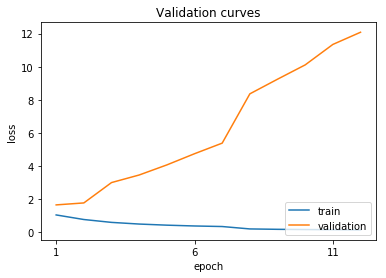

In [22]:
plot_curves(my.losses_train, my.losses_valid, step=5)

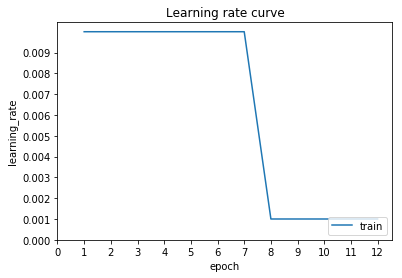

In [23]:
learning_curve(my.learning_rates)

## Мини-вывод по 3 модели
Видим, что здесь ошибка намного выше чем у предыдущих 2 моделей - `8.74`, так как инициализируются вектора рандомно. Стопнулось на 11 эпохе. На 6 эпохе уменьшился learning rate. Причем, видим, что есть какое-то переобучение (валидационный loss намного выше обучающей), и к концу ошибка все увеличивается (If validation loss starts increasing then it is time to stop). The validation loss keeps increasing after every epoch. Our model is not generalizing well enough on the validation set.

## Общий вывод
Наименьший loss (ошибку) показала 1 модель. Наибольший - 3 модель. Это и логично (описание в мини-выводах). Я использовала ещё accuracy для проверки точности, но эта метрика, как я поняла позже, не подходит, так как выборка не сбалансирвоана. Лучше сравнивать модели по ошибке. Во 2 и 3 модели сразу видим огромный оверфит данных, лучше работает готовая модель.